In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import psycopg2

In [191]:
def GMM(dat, k):
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,2,2))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
        
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:], allow_singular = True)])
            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim] / sums

        for m in range(k):
            sumCol = np.sum(p_class_given_data, axis=0)[m]
            p_class[m] = sumCol/len(dat)
            weightValLat = 0
            weightValLng = 0
            for x in range(len(dat)):
                weightValLat += (p_class_given_data[x][m] * dat.iloc[x][0])
                weightValLng += (p_class_given_data[x][m] * dat.iloc[x][1])
            means[m, 0] = (weightValLat / sumCol)
            means[m, 1] = (weightValLng / sumCol)

            covar = np.zeros((2,2))
            latCol = dat.iloc[:,0]-means[m,0]
            lngCol = dat.iloc[:,1]-means[m,1]

            covar[0][0] = np.sum(p_class_given_data[:,m]*((latCol)**2))
            covar[0][1] = np.sum(p_class_given_data[:,m]*(lngCol)*(latCol))
            covar[1][0] = np.sum(p_class_given_data[:,m]*(lngCol)*(latCol))
            covar[1][1] = np.sum(p_class_given_data[:,m]*((lngCol)**2))

            covars[m, :, :] = covar/sumCol
    
    pSum = 0
    for x in range(len(dat)):
        for m in range(k):
            pSum += p_class_given_data[x][m] * np.square(dat.iloc[x].values - means[m])
    mean_dist = np.sqrt(pSum / len(dat))
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

In [192]:
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432",
)
cur = conn.cursor()
cur.execute("SELECT * FROM machine_links INNER JOIN features ON machine_links.ccn = features.ccn") # query to get joined data
res = cur.fetchall()
df = pd.DataFrame(res)

df = df.iloc[:, 0:9] # remove the double ccn column
df.columns = ["ccn", "state_or_region", "reporting_entity_name_common", "machine_readable_url",'csv_headers','meets_standards' ,"bed_count", "zip_code", "medicare_medicaid_eligible"]

df.set_index("ccn", inplace=True) # index by ccn
df_zip = df.filter(['meets_standards','zip_code'])
df_zip.meets_standards = df_zip.meets_standards.replace({True: 1, False: 0})
df_bed  = df.filter(['meets_standards','bed_count'])
df_bed.meets_standards = df_bed.meets_standards.replace({True: 1, False: 0})
df_medicare = df.filter(['meets_standards','medicare_medicaid_eligible'])
df_medicare.meets_standards = df_medicare.meets_standards.replace({True: 1, False: 0})
df_medicare.medicare_medicaid_eligible = df_medicare.medicare_medicaid_eligible.replace({True: 1, False: 0})
df_bedMed = df.filter(['bed_count', 'zip_code'])
df_bedMed["zip_code"] = pd.to_numeric(df_bedMed["zip_code"])


In [193]:
GMMResults = []
for x in range(1,9):
    GMMResults.append(GMM(df_bedMed, x))

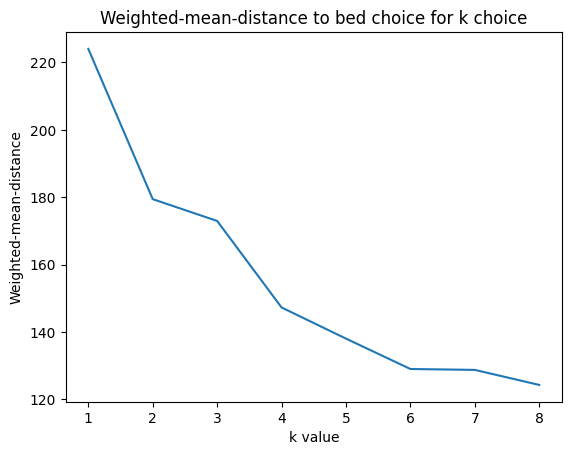

In [194]:
plt.plot(range(1,9), [kVal[-1][0] for kVal in GMMResults])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to bed choice for k choice")
plt.show()

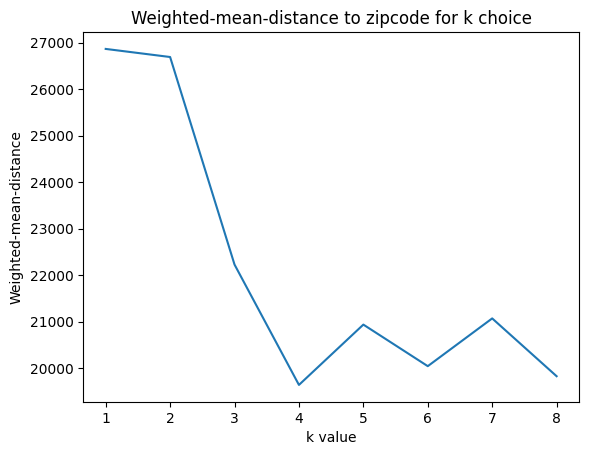

In [195]:
plt.plot(range(1,9), [kVal[-1][1] for kVal in GMMResults])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to zipcode for k choice")
plt.show()

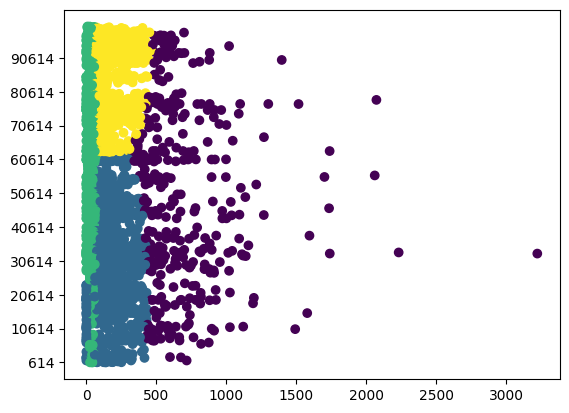

In [199]:
cluster = np.argmax(GMMResults[3][0], axis=1)
plt.scatter(df_bedMed['bed_count'], df_bedMed['zip_code'], c=cluster)
plt.yticks(np.arange(min(df_bedMed["zip_code"]), max(df_bedMed["zip_code"])+1, 10000))
plt.show()